In [3]:


import os
from dotenv import load_dotenv

load_dotenv()
APIKEY = os.getenv("APIKEY")
APIKEY_ANTHROPIC = os.getenv("APIKEY_ANTHROPIC")
APIKEY_VOYAGER = os.getenv("APIKEY_VOYAGER")

In [4]:
import pandas as pd
import numpy as np


In [5]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", APIKEY))

def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [92]:
import pandas as pd
from typing import List, Optional
import math

import pandas as pd
from typing import List, Optional
import math

def process_top_logprobs(
    top_logprobs: List,
    convert_type: Optional[str] = None
) -> pd.DataFrame:
    """
    Processes a list of TopLogprob objects into a pandas DataFrame with additional metrics.
    
    Parameters
    ----------
    top_logprobs : List
        A list of TopLogprob objects, each containing 'token', 'bytes', and 'logprob' attributes.
    
    convert_type : Optional[str], default=None
        Specifies the desired data type for the 'token' column.
        - 'int' : Convert tokens to integers.
        - 'float' : Convert tokens to floats.
        - 'bool' : Convert tokens to booleans.
        - None : No conversion applied.
        
        Tokens that cannot be converted to the specified type will be excluded from the DataFrame.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame with columns:
        - 'token' : The token, optionally converted to the specified type.
        - 'bytes' : The byte representation of the token.
        - 'logprob' : The log probability of the token.
        - 'prob' : The probability of the token, calculated as exp(logprob).
        - 'perplexity' : The perplexity, calculated as exp(-logprob).
    
    Raises
    ------
    ValueError
        If `convert_type` is not one of 'int', 'float', 'bool', or None.
        If `top_logprobs` is not a list.
        If any TopLogprob object does not have the required attributes.
    """
    
    # Input validation
    if not isinstance(top_logprobs, list):
        raise ValueError("`top_logprobs` must be a list of TopLogprob objects.")
    
    valid_types = {'int', 'float', 'bool', None}
    if convert_type not in valid_types:
        raise ValueError("`convert_type` must be one of 'int', 'float', 'bool', or None.")
    
    # Extract data
    data = []
    for idx, item in enumerate(top_logprobs):
        try:
            token = item.token
            bytes_list = item.bytes
            logprob = item.logprob
            prob = math.exp(logprob)
            perplexity = math.exp(-logprob)
            data.append({
                'token': token,
                'bytes': bytes_list,
                'logprob': logprob,
                'prob': prob,
                'perplexity': perplexity
            })
        except AttributeError as e:
            raise ValueError(f"TopLogprob object at index {idx} is missing required attributes.") from e
        except (TypeError, ValueError) as e:
            raise ValueError(f"Invalid data in TopLogprob object at index {idx}: {e}") from e
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Optional type conversion
    if convert_type:
        type_mapping = {
            'int': 'Int64',   # Use pandas nullable integer dtype
            'float': 'float64',
            'bool': 'bool'
        }
        dtype = type_mapping.get(convert_type)
        
        if convert_type == 'bool':
            # Convert tokens to boolean based on truthy and falsy values
            truthy_values = {'true', '1', 't', 'yes'}
            falsy_values = {'false', '0', 'f', 'no'}
            df['token_converted'] = df['token'].astype(str).str.lower().apply(
                lambda x: True if x in truthy_values else False if x in falsy_values else None
            )
        else:
            df['token_converted'] = pd.to_numeric(df['token'], errors='coerce')
        
        # Drop rows where conversion failed (NaN values or None for bool)
        df = df.dropna(subset=['token_converted'])
        df['token_converted'] = df['token_converted'].astype(dtype)
        
        # Assign the converted column back to 'token' and drop the helper column
        df['token'] = df['token_converted']
        df = df.drop(columns=['token_converted'])
    
    return df


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_logprob_dataframe(
    df: pd.DataFrame,
    y_column: str = 'perplexity',
    palette: Optional[str] = 'viridis',
    use_beta_model: bool =True,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plots a bar chart of the specified metric for each token with a density curve overlay.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing at least 'token' and the specified y_column.
    
    y_column : str, default='perplexity'
        The column to plot on the y-axis. Must be one of 'perplexity', 'logprob', or 'prob'.
    
    palette : Optional[str], default='viridis'
        The seaborn color palette to use for the bars.
    
    figsize : tuple, default=(12, 8)
        The size of the plot in inches, as (width, height).
    
    Returns
    -------
    None
        Displays the plot.
    
    Raises
    ------
    ValueError
        If `y_column` is not one of 'perplexity', 'logprob', or 'prob'.
        If required columns are missing from the DataFrame.
    """
    
    # Validate y_column
    valid_columns = {'perplexity', 'logprob', 'prob'}
    if y_column not in valid_columns:
        raise ValueError(f"`y_column` must be one of {valid_columns}.")
    
    # Check required columns in DataFrame
    required_columns = {'token', y_column}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"The DataFrame is missing required columns: {missing_columns}")
    
    # Sort the DataFrame by token (assuming tokens are numeric and sortable)
    df_sorted = df.sort_values(by='token')
    
    # Initialize the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Set seaborn context for blog-friendly aesthetics
    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    # Create the barplot using token as numeric x-axis
    plt.bar(
        x=df_sorted['token'],
        height=df_sorted[y_column],
        color=sns.color_palette(palette, len(df_sorted)),
        alpha=0.8,
        label="Bar Plot"
    )
    
    
    # Overlay density curve
    if use_beta_model:
        from scipy.stats import beta
        
        # Normalize the token values to (0, 1) for beta fitting
        epsilon = 1e-6  # A small value to shift the boundaries
        normalized_tokens = (df_sorted['token'] - 1) / (10 - 1)
        normalized_tokens = np.clip(normalized_tokens, epsilon, 1 - epsilon)
        
        # Fit a beta distribution to the normalized data
        a, b, loc, scale = beta.fit(normalized_tokens, floc=0, fscale=1)
        
        # Generate a smooth curve based on the beta distribution
        x = np.linspace(1, 10, 20)
        normalized_x = (x - 1) / (10 - 1)
        density = beta.pdf(normalized_x, a, b, loc=loc, scale=scale)

        # Ensure no infinite values in density
        density = np.where(np.isfinite(density), density, 0)
        
        # Scale density to align with weights (df_sorted[y_column])
        density *= np.sum(df_sorted[y_column]) / np.sum(density)

        
        # Plot the beta-modeled density
        plt.plot(x, density, color='blue', linewidth=2, label='Beta Model')
    else:
        pass

    
    # Customize the plot
    plt.title(f'Bar Plot of {y_column.capitalize()} by Token', fontsize=16)
    plt.xlabel('Token', fontsize=14)
    plt.ylabel(y_column.capitalize(), fontsize=14)
    
    # Set x-axis range and ticks
    plt.xlim(0, 11)  # Ensure the x-axis always covers the range 0-11
    plt.xticks(ticks=range(1, 11), labels=range(1, 11))  # Set ticks at integers 1 through 10
    
    # Rotate x-axis labels if tokens are numerous or overlapping
    if len(df_sorted) > 10:
        plt.xticks(rotation=45, ha='right')
    # Hide the top and right spines
    sns.despine(top=True, right=True)
    
    # Add legend for density curve
    plt.legend()
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [60]:

path = "/Users/jasperhajonides/Documents/Projects/datascience/llms/"
dfq = pd.read_csv(path + "questions_for_scores.csv",index_col=None)

# Clean the main dataframe
dfq = dfq.loc[:, ~dfq.columns.str.contains('^Unnamed')]

# Add score columns to the original dataframe (dfq) with a floating-point dtype
scores_range = range(1, 11)
for score in scores_range:
    dfq[score] = 0.0  # Initialize with floats

"Rate on a scale of 1-10 how reasonable this claim is: 'Eating carrots will give you perfect night vision because they're full of vitamin A.'" Respond with only an integer
   token bytes    logprob          prob    perplexity
0      3  [51]  -0.095816  9.086311e-01  1.100557e+00
1      2  [50]  -2.595816  7.458498e-02  1.340752e+01
2      4  [52]  -4.095816  1.664216e-02  6.008835e+01
3      5  [53]  -8.970816  1.270645e-04  7.870021e+03
4      1  [49] -11.720816  8.122959e-06  1.231078e+05
5      6  [54] -11.970816  6.326167e-06  1.580736e+05
6      7  [55] -15.970816  1.158678e-07  8.630526e+06


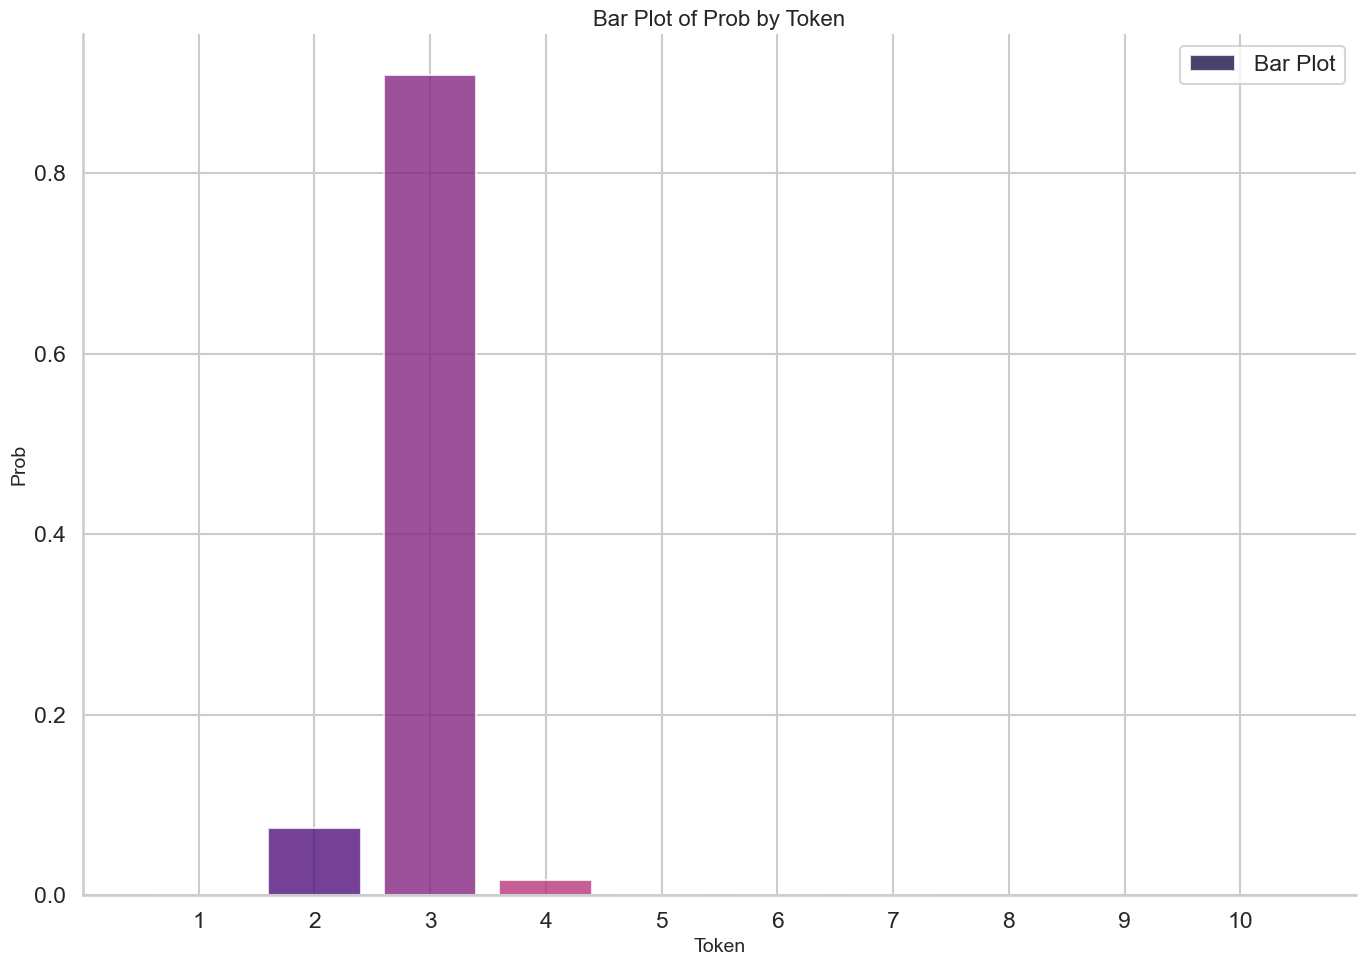

In [35]:
PROMPT= "If you had to pick your favourite number between 1 and 10 what would it be? Output a single integer"
PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that the humans destroy the earth by the year 2050. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that ukraine join the EU soon. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most impactful. What is the negative biodiversity impact of Spotify. Just output a single integer"
# PROMPT = "Weather in London is predicted to be horribly cold this winter, even worse than last year, in 2023. On a scale of 1 (not) to 10 (very much), how much is this person looking forward to winter? Reply with a sinlge integer"
# PROMPT = "On a scale from 1 to 10 where 10 is the highest score. How much do you fear spiders? Think very carefully and Return a single number"
PROMPT = dfq.loc[0,'question'] + ' Respond with only an integer'
print(PROMPT)
API_RESPONSE = get_completion(
    [
        {
            "role": "user",
            "content": PROMPT,
        }
    ],
    model="gpt-4o",
    logprobs=True,
    top_logprobs=15,
)


# Assuming you have the API_RESPONSE object as described
top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list, convert_type='int')
print(df_int)

plot_logprob_dataframe(df_int, y_column='prob', palette='magma', figsize=(14, 10), use_beta_model=False)


In [62]:


# Add score columns to the original dataframe (dfq) with a floating-point dtype
# scores_range = range(1, 11)
# for score in scores_range:
#     dfq[score] = 0.0  # Initialize with floats

from tqdm import tqdm
# Loop over all rows of dfq
for index, row in tqdm(dfq.head(100).iterrows()):
    # Generate the prompt
    PROMPT = row['question'] + ' Respond with only an integer'
    # print(PROMPT)
    
    # Simulate API call and response
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT,
            }
        ],
        model="gpt-4o-mini",
        logprobs=True,
        top_logprobs=15,
    )

    # Process the API response to create df_int
    top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
    df_int = process_top_logprobs(top_logprobs_list, convert_type='int')

    # Update the dfq dataframe with scores
    for _, score_row in df_int.iterrows():
        score = int(score_row["token"])
        if score in dfq.columns:
            dfq.loc[index, score] += score_row["prob"]


100it [00:59,  1.69it/s]


In [63]:
dfq.iloc[:,3:13].mean(axis=0)

1     0.137388
2     0.110229
3     0.133277
4     0.137056
5     0.033728
6     0.025582
7     0.022235
8     0.020276
9     0.072626
10    0.307603
dtype: float64

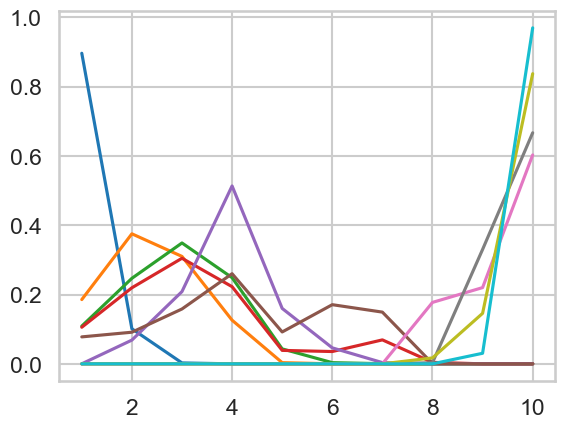

In [73]:
for i in range(1,11):
    plt.plot(dfq.loc[dfq['Score']==i].iloc[:,3:13].mean(axis=0),label=f'score is {i}')

# plt.legend()

In [64]:
dfq.to_csv(path + '/questions_for_scores_gpt4o_mini.csv')

In [61]:
dfq

,question,Score,total,1,2,3,4,5,6,7,8,9,10
0,"""Rate on a scale of 1-10 how reasonable this c...",3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Rate on a scale of 1-10 how reasonable this c...",3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Rate on a scale of 1-10 how reasonable this c...",3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"""Rate on a scale of 1-10 how reasonable this c...",3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"""Rate on a scale of 1-10 how reasonable this c...",3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"""Rate on a scale of 1-10 how reasonable this c...",6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,"""Rate on a scale of 1-10 how reasonable this c...",6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,"""Rate on a scale of 1-10 how reasonable this c...",6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,"""Rate on a scale of 1-10 how reasonable this c...",6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# RAG TEST

In [82]:
import openai
import math

# Define your OpenAI API key
openai.api_key = APIKEY

def ask_with_logprobs(prompt: str, model: str = "gpt-4o", top_n: int = 10) -> dict:
    """
    Query OpenAI's GPT model with logprobs enabled and return probabilities of key tokens.
    
    Args:
        prompt (str): The input prompt for the model.
        model (str): The GPT model to use. Defaults to "gpt-4".
        top_n (int): Number of top tokens to return logprobs for. Defaults to 10.

    Returns:
        dict: Response containing probabilities for "True" and "False" and their ratio.
    """
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", APIKEY))

    # Query OpenAI API
    # response = client.chat.completions.create(
    #     model=model,
    #     prompt=prompt,
    #     max_tokens=1,  # Only predict the next token (e.g., "True" or "False")
    #     temperature=0,  # Deterministic output
    #     logprobs=top_n,  # Include log probabilities for top n tokens
    #     stop=None,
    # )

    response = get_completion(
    [
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model=model,
    logprobs=True,
    top_logprobs=10,
    )
    top_logprobs_list = response.choices[0].logprobs.content[0].top_logprobs
    print('top_logprobs_list:', top_logprobs_list)
    
    # Extract top logprobs
    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    
    # Get log probabilities for "True" and "False"
    true_logprob = top_logprobs.get(" True", float("-inf"))  # Note the space before 'True'
    false_logprob = top_logprobs.get(" False", float("-inf"))  # Note the space before 'False'
    
    # Convert log probabilities to probabilities
    true_prob = math.exp(true_logprob)
    false_prob = math.exp(false_logprob)
    
    # Compute the ratio
    ratio = true_prob / false_prob if false_prob > 0 else float("inf")
    
    return {
        "response_text": response["choices"][0]["text"].strip(),
        "true_prob": true_prob,
        "false_prob": false_prob,
        "ratio": ratio,
        "raw_response": response,
    }

# Test the function
if __name__ == "__main__":
    # Define a simple test prompt
    test_prompt = (
        "Context: 'Drinking hot water will literally cook your internal organs because they're made of the same proteins as meat.' "
        "Question: Is this statement true or false? True or False?"
    )
    
    # Call the function
    result = ask_with_logprobs(prompt=test_prompt)
    
    # Print the results
    print("Response Text:", result["response_text"])
    print("True Probability:", result["true_prob"])
    print("False Probability:", result["false_prob"])
    print("Ratio (True/False):", result["ratio"])
    print("Raw Response:", result["raw_response"])


top_logprobs_list: [TopLogprob(token='False', bytes=[70, 97, 108, 115, 101], logprob=-0.0007121935), TopLogprob(token='The', bytes=[84, 104, 101], logprob=-7.2507124), TopLogprob(token='This', bytes=[84, 104, 105, 115], logprob=-13.000712), TopLogprob(token='**', bytes=[42, 42], logprob=-18.250711), TopLogprob(token=' False', bytes=[32, 70, 97, 108, 115, 101], logprob=-18.375711), TopLogprob(token='false', bytes=[102, 97, 108, 115, 101], logprob=-19.750711), TopLogprob(token='That', bytes=[84, 104, 97, 116], logprob=-19.875711), TopLogprob(token='\n', bytes=[10], logprob=-20.250711), TopLogprob(token='FALSE', bytes=[70, 65, 76, 83, 69], logprob=-21.250711), TopLogprob(token='\u200b\u200b', bytes=[226, 128, 139, 226, 128, 139], logprob=-21.625711)]


AttributeError: 'list' object has no attribute 'get'

In [76]:
logprobs= [TopLogprob(token='True', bytes=[84, 114, 117, 101], logprob=-0.0005533903), TopLogprob(token='The', bytes=[84, 104, 101], logprob=-7.5005536), TopLogprob(token='This', bytes=[84, 104, 105, 115], logprob=-15.000553), TopLogprob(token=' True', bytes=[32, 84, 114, 117, 101], logprob=-16.750553), TopLogprob(token='\n', bytes=[10], logprob=-20.125553), TopLogprob(token='true', bytes=[116, 114, 117, 101], logprob=-20.375553), TopLogprob(token='Yes', bytes=[89, 101, 115], logprob=-20.500553), TopLogprob(token='Question', bytes=[81, 117, 101, 115, 116, 105, 111, 110], logprob=-20.625553), TopLogprob(token='**', bytes=[42, 42], logprob=-21.250553), TopLogprob(token='False', bytes=[70, 97, 108, 115, 101], logprob=-21.250553)]

NameError: name 'TopLogprob' is not defined

In [101]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", APIKEY))

# Query OpenAI API
# response = client.chat.completions.create(
#     model=model,
#     prompt=prompt,
#     max_tokens=1,  # Only predict the next token (e.g., "True" or "False")
#     temperature=0,  # Deterministic output
#     logprobs=top_n,  # Include log probabilities for top n tokens
#     stop=None,
# )

test_prompt = (
        "Context:  'High blood pressure is mainly caused by eating too much salt because salt makes your body retain water, which always increases blood volume.'"
        "Question: Is this statement true or false? only respond with True or False."
    )

response = get_completion(
[
    {
        "role": "user",
        "content": test_prompt,
    }
],
model='gpt-4o',
logprobs=True,
top_logprobs=10,
)
top_logprobs_list = response.choices[0].logprobs.content[0].top_logprobs
print('top_logprobs_list:', top_logprobs_list)

# Extract top logprobs
top_logprobs = response.choices[0].logprobs.content[0].top_logprobs

top_logprobs_list: [TopLogprob(token='False', bytes=[70, 97, 108, 115, 101], logprob=-0.07889155), TopLogprob(token='True', bytes=[84, 114, 117, 101], logprob=-2.5788915), TopLogprob(token=' False', bytes=[32, 70, 97, 108, 115, 101], logprob=-13.828892), TopLogprob(token='The', bytes=[84, 104, 101], logprob=-15.453892), TopLogprob(token='false', bytes=[102, 97, 108, 115, 101], logprob=-15.578892), TopLogprob(token='This', bytes=[84, 104, 105, 115], logprob=-15.953892), TopLogprob(token=' True', bytes=[32, 84, 114, 117, 101], logprob=-16.453892), TopLogprob(token='FALSE', bytes=[70, 65, 76, 83, 69], logprob=-17.453892), TopLogprob(token='(False', bytes=[40, 70, 97, 108, 115, 101], logprob=-17.453892), TopLogprob(token='.False', bytes=[46, 70, 97, 108, 115, 101], logprob=-17.953892)]


In [102]:
# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list, convert_type='bool')

In [103]:
df_int

,token,bytes,logprob,prob,perplexity
0,False,"[70, 97, 108, 115, 101]",-0.078892,9.241401e-01,1.082087e+00
1,True,"[84, 114, 117, 101]",-2.578892,7.585805e-02,1.318252e+01
4,False,"[102, 97, 108, 115, 101]",-15.578892,1.714641e-07,5.832125e+06
7,False,"[70, 65, 76, 83, 69]",-17.453892,2.629487e-08,3.803023e+07


# llm-api-collection test

In [144]:
from dotenv import load_dotenv

load_dotenv()

True

In [96]:
import sys
sys.path.append("/Users/jasperhajonides/Documents/scripts/llm_api_collection")

import os
from llama_apis.llama_apis import LLaMApis
%load_ext autoreload
%autoreload 2


llm = LLaMApis(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    perplexity_api_key=os.getenv("PERPLEXITY_API_KEY")
)

# Call OpenAI API with default parameters
response_text = llm.call_openai_api(
    prompt="Is AGI the biggest danger to humanity. just True or False in json format {'answer': bool}",
    as_json=True,
    max_tokens=500,
    temperature=0.5,
    logprobs=True,
    top_logprobs=3
    # json_formatting="{founding_year: int, population: int, famous_for: str}"
)
print("OPENAI (text):", response_text)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
initialising
Extracting logprobs for JSON output...
OPENAI (text): {'json_output': {'answer': True}, 'logprobs': {'answer': []}}


In [97]:
response_text

{'json_output': {'answer': True}, 'logprobs': {'answer': []}}

In [92]:
response_text['logprobs']

{'answer': []}

In [153]:

import json
import requests
from openai import OpenAI

as_json = True
max_tokens=2565
temperature=0
model = "gpt-4o-mini"
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client if API key is provided
openai_client = None
openai_client = OpenAI(api_key=openai_api_key)

prompt="Explain oxford to a posh englishman. In 2 sentences. then format into json {founding_year: int, population: int, famous_for: str}"


# Determine the response format
response_format = {"type": "json_object"} if as_json else {"type": "text"}

# Prepare the messages for the chat completion
messages = [
    {
        "role": "system",
        "content": "Answer in a concise and accurate way with factual details.",
    },
    {
        "role": "user",
        "content": prompt,
    },
]

# Base parameters for the API call
base_params = {
    "model": model,
    "messages": messages,
    "temperature": temperature,
    "max_tokens": max_tokens,
    "response_format": response_format,
    "logprobs":True
}



# Make the API call
response_openai = openai_client.chat.completions.create(**base_params)

# Extract the content from the response
output = response_openai.choices[0].message.content.strip()

if base_params['logprobs'] == True:
    logprobs = [token.logprob for token in response_openai.choices[0].logprobs.content]
# Parse JSON if required
if as_json:
    # Remove code block formatting if present
    if output.startswith("```json") and output.endswith("```"):
        output = output[len("```json\n"):-len("```")].strip()

    json_output = json.loads(output)


In [159]:

        # **Start of Added Lines**
if (base_params['logprobs'] == True):
    json_logprobs = extract_logprobs(
        json_output=json_output,
        original_text=prompt,
        logprobs_data=response_openai.choices[0].logprobs
    )

AttributeError: 'ChoiceLogprobs' object has no attribute 'get'

## extract logprobs

In [158]:



    def extract_logprobs(
        json_output: dict,
        original_text: str,
        logprobs_data: dict
    ):
        """
        Extracts log probabilities for tokens that are part of the JSON values.

        :param json_output: The JSON object generated from the LLM output.
        :param original_text: The original text output from the LLM before JSON conversion.
        :param logprobs_data: The logprobs data from the OpenAI API response.
        :return: A dictionary mapping JSON values to their respective token logprobs.
        """
        import re

        if not logprobs_data:
            raise ValueError("No logprobs data provided.")

        # Flatten the JSON values into a single string
        values = []
        for key, value in json_output.items():
            if isinstance(value, str):
                values.append(value)
            elif isinstance(value, dict):
                # Recursively handle nested dictionaries if needed
                nested_values = _flatten_json_values(value)
                values.extend(nested_values)
            # Add more conditions if your JSON can contain lists or other types

        combined_values_text = " ".join(values)

        # Tokenize the combined values text
        # Note: The tokenization method should match OpenAI's tokenization
        # For simplicity, we'll use a basic split. For accurate tokenization, consider using OpenAI's tiktoken library.
        tokens = combined_values_text.split()

        # Extract logprobs from the logprobs_data
        token_logprobs = logprobs_data.get("token_logprobs", [])

        if len(tokens) != len(token_logprobs):
            print("Warning: Number of tokens and logprobs do not match.")
            min_length = min(len(tokens), len(token_logprobs))
            tokens = tokens[:min_length]
            token_logprobs = token_logprobs[:min_length]

        # Map tokens to their logprobs
        token_logprob_mapping = {token: logprob for token, logprob in zip(tokens, token_logprobs)}

        # Optionally, map logprobs back to JSON structure
        # Here, we'll create a dict where each key maps to a list of (token, logprob)
        json_logprobs = {}
        for key, value in json_output.items():
            if isinstance(value, str):
                value_tokens = value.split()
                json_logprobs[key] = [(token, token_logprob_mapping.get(token, None)) for token in value_tokens]
            elif isinstance(value, dict):
                # Handle nested dictionaries
                nested_logprobs = _extract_nested_logprobs(value, token_logprob_mapping)
                json_logprobs[key] = nested_logprobs
            # Add more conditions if your JSON can contain lists or other types

        return json_logprobs

    def _flatten_json_values(nested_dict):
        """
        Recursively flattens nested JSON dictionaries to extract string values.

        :param nested_dict: A nested dictionary.
        :return: A list of string values.
        """
        values = []
        for key, value in nested_dict.items():
            if isinstance(value, str):
                values.append(value)
            elif isinstance(value, dict):
                values.extend(_flatten_json_values(value))
            # Add more conditions if your JSON can contain lists or other types
        return values

    def _extract_nested_logprobs(nested_dict, token_logprob_mapping):
        """
        Recursively extracts logprobs for nested JSON dictionaries.

        :param nested_dict: A nested dictionary.
        :param token_logprob_mapping: A dict mapping tokens to logprobs.
        :return: A nested dictionary mapping keys to lists of (token, logprob).
        """
        nested_logprobs = {}
        for key, value in nested_dict.items():
            if isinstance(value, str):
                value_tokens = value.split()
                nested_logprobs[key] = [(token, token_logprob_mapping.get(token, None)) for token in value_tokens]
            elif isinstance(value, dict):
                nested_logprobs[key] = _extract_nested_logprobs(value, token_logprob_mapping)
            # Add more conditions if your JSON can contain lists or other types
        return nested_logprobs

In [121]:
response_text

{'founding_year': 1478,
 'population': 6000,
 'famous_for': 'Extensive portfolio of educational materials, research publications, and innovative tools'}

In [125]:
[math.exp(i) for i in logprobs]

[0.8393936021869554,
 0.9841616096167255,
 0.9999207774982681,
 0.9998045845560857,
 0.9999925349918634,
 0.7911228844449185,
 0.5699179932473015,
 0.7809381543890901,
 0.9703104530505471,
 0.22236891434578956,
 0.8201618173178157,
 0.9102790619488593,
 0.7907811140913524,
 0.47851369873673116,
 0.8196895565337163,
 0.9961766136257195,
 0.7654241456820033,
 0.9369646033794586,
 0.6177449987863084,
 0.4949471795930338,
 0.7894871906925586,
 0.845536949701438,
 0.99999861435166,
 0.6906042361715172,
 0.628632093752556,
 0.9997473942801988]

In [135]:
prompts = [
    "In a short sentence, has artifical intelligence grown in the last decade?",
    "In a short sentence, what are your thoughts on the future of artificial intelligence?",
]

for prompt in prompts:
    API_RESPONSE = get_completion(
        [{"role": "user", "content": prompt}],
        model="gpt-3.5-turbo",
        logprobs=True,
    )

    logprobs = [token.logprob for token in API_RESPONSE.choices[0].logprobs.content]
    response_text = API_RESPONSE.choices[0].message.content
    response_text_tokens = [token.token for token in API_RESPONSE.choices[0].logprobs.content]
    max_starter_length = max(len(s) for s in ["Prompt:", "Response:", "Tokens:", "Logprobs:", "Perplexity:"])
    max_token_length = max(len(s) for s in response_text_tokens)
    

    formatted_response_tokens = [s.rjust(max_token_length) for s in response_text_tokens]
    formatted_lps = [f"{lp:.2f}".rjust(max_token_length) for lp in logprobs]

    perplexity_score = np.exp(-np.mean(logprobs))
    print("Prompt:".ljust(max_starter_length), prompt)
    print("Response:".ljust(max_starter_length), response_text, "\n")
    print("Tokens:".ljust(max_starter_length), " ".join(formatted_response_tokens))
    print("Logprobs:".ljust(max_starter_length), " ".join(formatted_lps))
    print("Perplexity:".ljust(max_starter_length), perplexity_score, "\n")

Prompt:     In a short sentence, has artifical intelligence grown in the last decade?
Response:   Yes, artificial intelligence has grown significantly in the last decade. 

Tokens:                Yes              ,     artificial   intelligence            has          grown  significantly             in            the           last         decade              .
Logprobs:            -0.00          -0.00          -0.00          -0.00          -0.00          -0.28          -0.08          -0.00          -0.00          -0.01          -0.00          -0.00
Perplexity: 1.0313527145176409 

Prompt:     In a short sentence, what are your thoughts on the future of artificial intelligence?
Response:   The future of artificial intelligence holds great potential for transforming industries and improving efficiency, but also raises ethical and societal concerns that must be carefully addressed. 

Tokens:               The        future            of    artificial  intelligence         holds         

In [137]:
API_RESPONSE.choices[0].logprobs

ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='The', bytes=[84, 104, 101], logprob=-0.21371108, top_logprobs=[]), ChatCompletionTokenLogprob(token=' future', bytes=[32, 102, 117, 116, 117, 114, 101], logprob=-0.020439228, top_logprobs=[]), ChatCompletionTokenLogprob(token=' of', bytes=[32, 111, 102], logprob=-0.0001201125, top_logprobs=[]), ChatCompletionTokenLogprob(token=' artificial', bytes=[32, 97, 114, 116, 105, 102, 105, 99, 105, 97, 108], logprob=-0.00017934572, top_logprobs=[]), ChatCompletionTokenLogprob(token=' intelligence', bytes=[32, 105, 110, 116, 101, 108, 108, 105, 103, 101, 110, 99, 101], logprob=-9.610702e-06, top_logprobs=[]), ChatCompletionTokenLogprob(token=' holds', bytes=[32, 104, 111, 108, 100, 115], logprob=-0.26459104, top_logprobs=[]), ChatCompletionTokenLogprob(token=' great', bytes=[32, 103, 114, 101, 97, 116], logprob=-0.5487015, top_logprobs=[]), ChatCompletionTokenLogprob(token=' potential', bytes=[32, 112, 111, 116, 101, 110, 116, 105, 97, 10